# Classify land cover to measure shrinking lakes

#### Compare imagery to calculate area change in Lake Aculeo Lagoon, Chili.

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Get data and model for classification](#Get-data-and-model-for-classification)
* [Visually compare Lake Aculeo Lagoon over time](#Visually-compare-Lake-Aculeo-Lagoon-over-time)
* [Classify land cover in 2016](#Classify-land-cover-in-206)
* [Classify land cover in 2017](#Classify-land-cover-in-2017)
* [Clean up the classification](#Clean-up-the-classification)
* [Calculate area over time](#Calculate-area-over-time)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

One of the important freshwater waterbodies of central Chili, Lake Aculeo Lagoon shrank over time due to climatic drought, drying of surface tributaries and streams that provided a continuous ﬂow of water and high existing demand of ground water [[1]](https://www.researchgate.net/publication/338731020_The_First_Drying_Lake_in_Chile_Causes_and_Recovery_Options). The lagoon dried completely in May of 2018. Those whose livelihoods depend on the lake are alarmed, as the shrinking lake changes the land cover of the area and impacts the economy. In order to help them identify and save their waterbodies, we'll generate land cover and compare imagery between 2016 and 2017 to quantify the surface area of the lake and show changes over time.

Manually extracting features from raw data, such as generating land cover maps, is time consuming. Deep learning automates the process and minimizes the manual interaction necessary to complete these tasks. To quantify the change in lake surface area from 2016 to 2017, we'll classify the land cover in both images, identifying the areas covered with water and distinguishing them from other land cover, such as vegetation or urban areas.

This sample aims to demonstrate how ArcGIS pretrained models can be used to generate landcover from imageries of different time periods for further analysis. Once the land covers are created, we will use arcgis.raster submodule of ArcGIS API for Python for calculating surface area reduced from 2016 to 2017.

Note: This sample is supported with ArcGIS Image for ArcGIS Online. For more details read [here](https://www.esri.com/arcgis-blog/products/arcgis-online/imagery/introducing-arcgis-image-for-arcgis-online/).

## Necessary imports

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.learn import classify_pixels
from arcgis.raster.functions import equal_to
from arcgis.raster.functions import extract_band


import pandas as pd
from datetime import datetime as dt
from ipywidgets import HBox, VBox, Label, Layout

In [2]:
gis = GIS("home")

## Get data and model for classification

Search for  Multispectral Sentinel-2 Level 1-C imagery for year 2016 and 2017 on the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home).  Download imagey of the desired time period and publish them in ArcGIS Online. The code below uses the `get` method to get items.

In [3]:
sentinel2016 = gis.content.get("a264d1eaa8bd4ff2a0a1e27b59daa7d3")
sentinel2017 = gis.content.get("ea192d03d1324c62a2cb91e26e3a0ece")

Search for the <b>Land Cover Classification (Sentinel-2)</b> deep learning package in ArcGIS Online. We can search for content shared by users outside our organization by setting `outside_org` to True.

<Item title:"Land Cover Classification (Sentinel-2)" type:Deep Learning Package owner:esri_analytics>
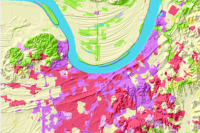

In [4]:
model = gis.content.search(
    "Land Cover Classification (Sentinel-2) owner: esri_analytics",
    "Deep Learning Package",
    outside_org=True,
)[0]
model

This model is trained on [Corine Land Cover (CLC) 2018](https://land.copernicus.eu/pan-european/corine-land-cover) data that contains 16 classes. The screenshot below shows the color code for each land cover class.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAWMAAAGDCAYAAAD+hnFjAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAADF/SURBVHhe7Z1Njuw4km5zgbe2UpOqBTQaNe1pXrwNJN44kctIIBCbSFRPawPRNP5IZkYjJY/wiKDczwGEDImk0Wg0fk6X35R+eQMAgG8HMQYAWADEGABgARBjAIAFQIwBABbgUIz//ve/3/UAAICeU2L81y9/u8uBGAMAxCDGAAALgBgDACwAYgwAsACIMQDAAjykGL/++s+3P/63nnwJ/3774x8/3n78+PH2z9//Xa8N+N8/3v7562s9AQAoLCvGr7/+ePv5Uk80Lz/ffhyI2ZeL8QmfNt4pxv/+/Z9J7H++IeMAjwlifAdEKA93xA12xgAQgBjfAcQYAD7KxcVY7tUm4X1JAvfjx9uPf/yRrjQxfn37Kdfq0YulLdd9FXF93e4D+/Kd/V5xOfbbCOL/dl2LbxXjctuhb5epY2w2ct+BiJs+6tgB4JpcfmecBckJUREpvTsuoqkF2e6eRZjVufTRRFAQIZzcr+12xqm97Uv1nW0l/7Sw5v6U/VrHjN+JcR6jOs/i7sQaAK7DQ4ixrxe3FcEdC6pp4/oQhv4kDm9TaHsiqsEu1tiI6mgxzmI9HgsAXI8HEGO9wy3E94zrLY12PQua7KD3Q4uxF9fbxNjfvkiHFlIn9Bkv2L6OF2NuSwA8FMuK8Wi3KaKor8diHAmn2hlnIbY7S9PmQ2JchNjUfc/O+EiM2RkDPBTLinERnEDUOhGNxXh6z9gLou/rw2Lc923EWO+UBT8uqTMT40Qeo7fh2wDAZVhXjIUmXNvR7wbHtynm/5pCBHSzm4T5NZ3fR4wTxu/ki/xrjyaUVVRN/35cJ8RYKB869eC2BcClWVuMAQCeBMQYAGABTonxPQ8AAOg5FGMAAPh8EGMAgAVAjAEAFgAxBgBYAH7AAwBYgFNi/Off/nOXAzEGAIhBjAEAFgAxBgBYAMQYAGABEGMAgAV4aDHunqa2CtFT2eBG5NGkX/lMZ/9oVID7sqwYzx5ZeZavFOPySMyT4oAYx0hcfpydd8T46ty0Zp4AxPgE9/DFgBjfgZXE+EGF+otfWHD3dXYxEOMTIMYrghh/Oojxl3IRMa7vr8uvJxq92UIWxP7mCxFhK8bB26GdKEqfun1ps1/bXuVUk7TVz352AmvbmiS7SYztuOzicGVufGX8r6pO8b98PazXOp9dnHO5HksvOjpudl6qSMmbTkzZaExy3Y7B2O7G7uZTIzFu7ZzPfVwCEeja17F4wTX15Cg+2T72duPxBLF3Od7nZ+HMm20E07efR5fT//pvXTe2Z9dXQb955zDO2zqwvu++zfPu0biIGNfFq5JTyvdEKOU6MZrg7NdqstezjBbFmowFu/CsL4m6AGcCa18HJX2rc1d3TD+ufdx9WR6DHmNd2JufbaFvfZdkH8e5nivfc1zdPBhRMXGs5UZUjsZk/Y/rCa6uwZXl+ZrExZfncz1/fRwsUu7Kch/9tfl4bKxMuYmr7S/H2OR2seX7MvPkx5jPXU6bPnuOxPhUnF2u6P7NudQ1efR4XEiMXWLryZFJDybKJsuBGE8m2ydJWFfbCugSa1J3YzCuzKBM+okXsOA+FBI2Rn2cs/h2Nmocw5j1QmFiNxtTbuvmSGPGc1DX4MbVxcX6aWK40cdmJygL+ujoxuNs6PiGsS50Mc64efK5nzBzG9k/GMMpMZ7EOfepyv04IvuPzIXE2CWTTp5R0qTr+2QeiLEgdmTnmA6dBF2y+3aCvybn1VY7Rkk4ZLYYJmPerpvxC30MejGelQt+kdsxlmNfkPYbQmI2pq5/OXe2t7ZBTmikH91Ofwh1cbFz3M13pRvLhvjSj9P3cfN4JL5aINWYtO3YL+WTt9PQ16OcnM5V6uGEGM/i7PuM4i7XyphHsX8cHkeMg2SzyRKI8STZdP9dkkSJq6/J364vYyNqHzEYV2ZQJv1sY+4WwyeI8ci/SijGwza6f/nbxd3MV5ATja4PqXteJEwMN5wNQ1DW9fGO8Uzi6/01djP+Q7OPlczt1n+Uk8a/nj43bouz7zMeRyNYvw/GY4hxLncLSBKp20Hoc5ncfWfiE0v33yVdlLj6mvEtIeepr1ESjunHtfsyGrOKU7cY7izGcpbiZBas+KDG3u/ajsbUbMvfum1pNxWvhvjgfbphZ1zmy/qdxznZnZn2QtfHO8aj8sjPg+6v+KbbFtu+vomJH2OUk6r/kGxj71d8vDnOqs8+F3W8EOOLiLFQkzt/pUlHKnsNhaTVSfZMMrj2XeLK9ZocLokyQWJ5X0ZJaMfqmfjly3yydovh/mIsFDGIfRh/hVZttjG5/re4y5HsyL/KGNV1GJ9Sm5u+PgumbxE2+VcB0VgqyWapW30K+rh5PFJ/y/FRzFqMdW67D+mKnSc3FpeThb3PyJ6g81zq3BRn3+cWn2rDxGu2Rh6DZcX4eZiLCsAR8QceXA3E+LsJdyQA50GMH4NTYnzPAwDuC2L8GByKMQAAfD6IMQDAAiDGAAALgBgDACwAP+ABACzAKTH+7Zc/73IgxgAAMYgxAMACIMYAAAuAGAMALABiDACwAIjxneifbvaIPP5jDAG+i2XFuDzu7+gRifv/k18e5fd9QoEYPw/flWvfnePwuSwtxv/8x0jg2rNb13lACmL8TchT72YPQL8D5hm8C7GqX/A+lhbjn7/HC60I3x9JGBDjrwUxXgnE+LFYW4xTovUJJw9jFxEWYVBibJ4LXOvImxS2NwX0IiK221sExu9li7BvXRARtmIciJbxr5Zvb4dIRy6T682u+6Cpb024xefytTaqey4++9srWvmBGMsYt/pu3lyZfWNJ8bW8TeNM++KDGZ8c2aYbWx53y5lsqZLG4uLXx1bPhxzVhpnLgmkbzF1528heZ/rBHYw1s/U78EtwcbZrZ5Jf8O0sL8YtkTe2c0ksl4SqXkn8PZHzwvXlod0jihDrxdRE4bwYVzHfxKCeq/Fkm1osqjDqxdXV0bh4hOOfxKf0p8fQFrIbVyOLgF7gan66skH89fhym9aXE1M9V1IvElVz7ViMvT86HlLWfTCout1Y/Hjzuc8P70/jYKyu384vY9faMvWl7ih34FtYX4yHCeUS+ihRc/26uMNEjBZsgCyOIIll8d4mxravTgy9Db0oFf04B7gxT+OT/YvsBuOqiL3Rbi8uE1sqBsH4tI/DcQZz2deN5jb139qJjcG4hM6enstBWzOfgY82XyzTsaoY+XphOxXXWZ/w/VxAjHUSqQXkF3OXqMHia4smLyDZ5fnDtwkYiKJc3xNd9dUw/ok42PJ+oTgbxv7O0aI24zNiPIlP9i+KRe93YyggiVGZuR6Mz7YrHxBlLMqHQOj6sZ0QY2dD0/mv53LUVl/X9StzYZyM1eS49UvOzXy3w7Up10/kOnwplxDjltj2bc8iHiqhukQNFl9LbL1QbkXEOGhrF5cTUsGIeC9qZ8Q4+hDohKIi1409N+ZjMY7sBuOqdP0p4jKxpXw4FGOFHkswl6fE2NsYjEvo/JD6bS4GbWU+t/nS9StzMVZ4P5Ud79cwXiHjuYTv4RpinJBz+2nuFnOXqH5B2uTL9vQCGYhsTxEqs5Ckbdpt6Gtifz+XvnV/7xTjZEPHJC/4gc9h/FTdo/iU/rSPZdzn7xkrAezKqj8u/l6c9jE437RA+bJEP7YaKxN/H4/en3bezU0giqatH6+rL4zFeDJWZyf0q5uDFkM1H5k+bvC9XEaM9eIoSDKNE/5QbBJ5EeWvbHL0ZaZ/QxOmeqTFYnftgvSnbBv/pL3tr1+czt8qVsZnJSY9un8ZSzo34nMcnyLIzoavo8lioOvX64Irs3OZmIpxwvhifd9iUm1GYmznTMptPIRhbDffq12Xa4Jp6/yL6o/FODEaq7fj/TLXymH6cGXj/IbvYFkx/l56sfx2ArECgMcBMY4IdjLfDmIM8NCcEuN7HvBOEGOAh+ZQjAEA4PNBjAEAFgAxBgBYAMQYAGAB+AEPAGABTonx22/pjzsciDEAQAxiDACwAIgxAMACIMYAAAuAGAMALMBzivH2VKxPfBgQ//vyB/iGBzUxX46DJ/TB3bmAGNdHH777wT2SVPpRgmKvf+TgmccJ5sckTh9bqXjCxX1TfKYgxt8PYvzVrC/G+QlqP29IDCe2HV+UZCzuD+DEOMXy/R/GJ1l4vuRD7vyzh4/y/yyI8VezvBi3RJw+jNuAGF8fxFiDGD8Hi4txSojta6/+u1ETRhar3AP+n/9n3mTQ7glvb35o9epRFp9b+IKppxLbL1jz5gS3AM4ubukrCU3+il9tde3cGxq8MJUPqtc0jr3O4eKd+S50MdCLsy74l2qjzUs3ZqnXbKRj8ztY6PkbULuyz4mOixzF/lF7lxft+nvmS2z4vHPXjI9djgbl0t7NYWxDxqGuK59N/XB8cqgYtVjk42i+pV0QY4Xk3FbfjHmQG/l6s58ON/7p3JiysU9XZ2kxlgnXoiIJaEWmTrCZ2JoMajLta3h8ku0LP5OTUp3nRKjnqWxfsK6drieYuhNqou11xT/lby7343Fjrgtpi433pePYd5v0Nc7qWvbBC08XH/vBIm3KebDQxYdtTMGcmDk+0z7KC9UmGHM8X9Kuj3+LdTgX6rwrz/3aa2dsmLx3vkq5jbv1N9sz8XLxC8uTTz7GDRPr1KMIsx9PJ9A2F+w33dncuPG42DwSC4vx0YITgsQLrp0XY/l7sqt0i8DSJ824rkLG5ERNJ6pdaA0ZwzxBuwU8xfoetjULZFBHj1l88mK9cTS3ek4S3fjOtLc50HN+vqxwqL6DubN2Az8TRrwObQxirTHx8WOPY7GPScoj+7HvIW4Mnb/d/Akz+zeO/0FYV4xlAvOnsz98ovkJ7ZPvNjHuE3fDL9jOR9XW1x1hRKTgxThKRHM96Gsvl/HG/sW+j2JgYx2+9FP7Ifa7BdgIFmInpqq8s3Vj+8ZwzKVsOF9abLQvct3Yc3Z1O4329chGos8BGZ+rb8au5yaoW48yXl+/MYhhRXwy9owYO3td3Nvh5tiUjcYw9unqLCrGowRJ6MUQJkzf9lN2xuKHWWiuX113hl6YlffsjH2dfgErpr6PYmDjdkqMIyHKBGIq9UfzasqEG9sLnT+3zVcbrxn3SGwbWWidH4L29chGws5lMD/d2PXc+HNPYC8TxLjS5aQbQyjGZv4cR3OjORGvq7KmGE8DrpNEJq1PGC9E58U4IYlhylX9VGbERidYbqf60XVnyFhdopqvxVJudgllfL5v39ehGB/4bmNQFqy+dijGtY32a/whIzHWY3JzEuTDTe2FE2PWvnbk8j/i1/t7u6pOV57n0147smHyIY9Nx77OjbPXiXWX07fNt8bbz/6bMfvcKPZ0fGVMm8/Svx//5p9br1NtuDZLirFM7mxh7OXBohPyZO7JdJMYC1t7OWzSar9yErZ6KZlMP6au9OETtHIkxkJbwKovg/NL8AvGM/Vd6GJg43YsxkJb1Hs/O1VA85Hsmjj4Odnt7PZvaV84P18Rpb+ojrFrcqtgykVIJLYmFgc2tvmv/pp8SNfkXy5oe9vcKTtmPoPc6Mr9OtHo2Ne6UzEWXC44QT2am61Mr8cHY+Ef8B4Jm6yXRATgQXckX033YQuQQIy/gvTJfqXFZ75CZsquBgG5lRI3swvNu9rH3d3B+zklxvc84BrYr80I8fuxX+kf+Ws2fIxDMQYAgM8HMQYAWADEGABgARBjAIAF4Ac8AIAFOCXGb2///y4HYgwAEIMYAwAsAGIMALAAiDEAwAIgxgAAC/B8YnziORHxU6fO8ZG255g9TQsArsoFxLg+es89cvDdIMYAsCDri3F+Tu3P+wkQYgwAC7K8GMvTw+QRhHd7BixiDAALsrgYJ+HZHmiu/25UYUoCmx9P2G5l+DchaHGsYty9faEWC52gGnvBWxIU87a6TG6/pHN5S8NWHohsG9tWjhgDPCJLi7HshrXwtV3yTnQ/Wa4pscpiqM6ruOndcX6YuhJkI6i5fSCiWnAVVoznvpQPhP28e6h79lW1T3+VZ+PqawDwCCwsxsEOUMSsE96xMBZcHRG44MdALfRaUPsPgMTAhtDtjA3Wl962HrPUjXbh7IwBHpF1xdh8PdeHFju382x0ba0YR/eM9T1pL8bWVj3OivHEl164vRj7cmEwZgC4NIuK8UiIEmZXGgiTlJt7wM6Wab9z0854ghHYA1+OxZidMcCzsKYYy+2I7se6hhesQIy12Mq52xnLDvVj94zHAt2J8cSXuRgncn09vtI394wBHo8lxVh2o9GthMZeHohxwtxaSGLoBVLamjpO+DuRzIK815/7ZtvOfDkUY6F+eLTj5ws7Y4BHZOEf8AAAngfEGABgAU6J8T0PAADoORRjAAD4fBBjAIAFQIwBABYAMQYAWAB+wAMAWIBTYvzXf/1ylwMxBgCIQYwBABYAMQYAWADEGABgARBjAIAFQIwBABZgWTE2j57cHh9ZCwEAHoylxdiKrzzH94kE2T+YHgAemguJcXkjx+zB7g8FYgzwVFx2Z2xuY0TvmXupb+eoZUXIX+tri+Qob9nIr1xqdpz4mbJZH/kI3r5h3tJh3+rR+zMYWzqGH0AD+9b2ft3atf60N2+bMXdjKnMQtgeAD3HJe8a5TAun20XmcvcqpSZcm8A3IdvaudsgVZwaWaR8H0qsfHmxr8XMvS7J+5Nf7eTKtT2Pt6/b5zIrll3Mcn1VJ5874Xd9iA3jr48xALybS92myIQiUHeqagfYte3ETcTRClbZUQ7kxfXb96HF1vrTMPYDsTU2g/IdsT+Ij+DbZqFVwl0xHyADcdU+T+MDAB/immIsO9ru0GLcC6EIlBUSt1NNeLERH0wfRox9H16MXdt6aDH2wnabGAdjbHjbA6E11+XvqD/nxx6TSf8AcDMPsjO23EOMpf+ZoB2L8YFYfViM5zvjzvc77IwtffwA4P1cT4wTeXemhUqEayqUiXeIse4/93lajBPik7Ev5apN54/r8+hDJ7Rfzwe2TcyyQCt/8vnsnrH/gEGMAe7JJcVYyOKyff23onAPMS7lex8/X9L5LWIsZDHTNup1YSCYe539Voevt2Hsz4VesDFz/osYJ7HOu+WtjhtPFexWPpsfALiNZcUYvpgqxgDwPSDGUECMAb6VU2J8zwMWBTEG+FYOxRgAAD4fxBgAYAEQYwCABUCMAQAWgB/wAAAW4JQY//XX3+5yIMYAADGIMQDAAiDGAAALgBgDACwAYgwAsACIMQDAAiwrxvZxjzyyEQAem6XF2Ipveb7wRwS5twkAsAYXEuPZK4DOgRgDwKpcdmcs5dstDPfoR11WxNu+tWN7y4W8KcO1FcHf+q3lzZ657m01zNsweC0RAJzjmveM3WuFpO52bgTWvrdN6hmBPxLjKqxdGyOy+nVL7j1xgX0AgIhL3aYYokVPBHTwIs93ibGx5V/KWdC3T27yGwCgclEx3l/WuR1aVPPutVz3O+ibxdiUB/12/eg63KYAgHNcUIyL2B2JakPbOSPGpk4oxv3OeMhklw4AoLmoGGtBrDvRKpr6loGg7fiyVPr2073iXna0YzFO5Dr+nnGzoe8fJxBjADjJNW9TiMhttwiSEL5o0dS3CXaRzmztegFudee3KSq6TTqMn6ZMf2gAAIxZVowBAJ4JxBgAYAFOifE9DwAA6DkUYwAA+HwQYwCABUCMAQAWADEGAFgAfsADAFiAU2L89tdvdzkQYwCAGMQYAGABEGMAgAVAjAEAFgAxBgBYAMQYHo8X+1quz0eeFMiLBOBjLCvGw0doyiMqo8dawqWRR5fe7c0oiDFckIcX4+lzkeExMWLsX0bwGSDG8HEQY3g8EGO4IA8hxlJ3e7vG9pojeQWSuq7fumHeFOL6qfabza1Mrqs2/ddgWZB7udjoX/PU19mpr2zS/XSvbJq1F1y5/9ofxM682cTEbC5gJuZHfvhYRDEO3qoSz6vY9r4lv3Wskv3cl5vnFo9+XqSv3WYpf61j2K+Pxyw+TcTY+GF9P9VXlwc2t+06OT+HsBZLi/GWjP5QCyHX0wvDCY6Um2TNC0MnqVvcdeGYNlkg9WIrYrMvaH+eyG3mdawolHK98MT3W9vr8s5vFxtBbLSxmlhJHDoRqCQ7up8jP7tYRDGWa5N5FT/Ludj3IjMQ40xf38atoMW4+Ov6OBzzSIxdWR67mxPXlx97rmNio+uL+O7np+cQluPaO+Mw2ezi83ZCu1ObYi9ooxfVIOmlr23BugVVkIXUFmYvGsbuUXspf4cPWowjkTrFNH4F40dUR65pG1qwDEGcJA7aXvLHCqWtf0qMu1g7TB3pY+Svx/nj+wrjF415R+f0u+cQvp3ri7HslLtjT1xvR877+unQNs1CHC0EdX20eNP1bWFInahfI8ZuQeuFedR+4sN2PaijxVjY4zNe/MVX7UM6Jn1k0nUjxr6OvqbH3RHNx/3FuBe0yZhz2USMJSa6nY6t70vGbuoGbYI6t88hrMYD7owtkRiHdhtaFDJlEXZt8oJQQhj4YRa99jskWNB6fEftBz7IeGc+jOOhd+2aIB7a7sAPE4suxgl9Tce2Q/p3IqPjJCQfdoHr6/di7OqY9sLBmHP5wN8uHgd9+bF4gtjcPoewIpf/AU/qGYFxyd8tvJzMenG6hSblXijEpknq0sYueH2eyG3mdcS36YI2C/NM+8gHbVMWpxWCfVcl7XVcZmLcx+/YD3UtirG7Fs5rPY/GbQQv1dX9d7mUc2AfW7Y3262eGnMUq4TyO5NjMevrIKdNTiTyWG6dQ1iRy4uxkJM3fy2TwyVfTdbZ1zyzGKTM2c/kRTRok6kLtNVJNroPAl9HL6pcFvje1Rm1F1x5tBD1OKqP5oNoazuIv2Dqpbi++JgdxCKKcXDNzOswDjKvSXR0uRe4bcx7PIoAFxtS9/A2xXTMwdwpzDhSm+NbIvOc1r5LXF7fM4ewHMuK8SMw/EB5QogFwBzE+C64r/9C3o2Nd0uPC7EAeA+nxPiex8Pivh4+tfgQC4CbORRjAAD4fBBjAIAFQIwBABYAMQYAWAB+wAMAWIBTYvxfqdo9DsQYACAGMQYAWADEGABgARBjAIAFQIwBABYAMQYAWIBlxdg+QnA/ePIXADwiS4vxGsIrz6p1TyEDALgziPEhiDEAfD7XFePt7Q3lsG9LqK+baXXaGxmmb0GQNq2siu/oUZDmOo+HBICPc7F7xlX4uoeVl9fw7IJcX8ujX+OTBVTvcO2O14i/1N1e4+N3xu5cfHGvCwIAuJUL7oyL0HZlWWybQHsBHdhTQtq/r65x0hYAwAe4qBhbcSzo6/K3vX0g9vqddjrUrnavo+1H/cm1VpfbFADwcR54Z9yL8fndbL3nnP+OxFhhbmkAALyPa/6Ad+qesduxhveMWx9ecLUYe19sGWIMAPfgmmIstH8pUQ97vzcQYyEL8qCNKzN9b31Vm6bvya4ZAOAky4oxAMAzgRgDACzAKTG+5wEAAD2HYgwAAJ8PYgwAsACIMQDAAiDGAAALwA94AAALcEqM//zP3+5yIMYAADGIMQDAAiDGAAALgBgDACwAYgwAsACIceX11wWevqbePPKppH7it5p8AHnqHa+fAng3C4txed7w/qjK4JGYd2RtMR48EvS9IMZPizya9seTPH/7Q2Otj9SdPsb3ziwqxkWIjWCIUH1iEi0txvcWT8T4shw+59vgX5oAQ0Zr7wtZVIzd2zS+gHXF+BMWFGJ8WRDjTwIxHiFifJxE+WtIu42x7ZprAr6UrxnlepSUqQ+10y5iLP3uNo8ES94o3fcvOB/y0X+4GP8lEaKEiERO6m12vZ/1g6zViRIsi/Fr8nG30S3w+jUtLK9+Nv9zWfXTxCQY8zhmhXhOC7MywZT7/AliK77s49Jz73OlIjZ8v/6anM/sdOV1vmqxEI/T5qa2HcbUzZ9+S43NF8nVoF5FbB/misH6aeuOYjyL/dy/zCjmfqwmJns9mzdtPUm/ri/Tz8G6k8Pliu7Hti2se894C5yfnEIemFpcOSHreS4zgTgjxr6vkgRR0DJVfBq6f6HY2yczLFfn20Trawmp1wmhSUjvZ01eZ8dQ+9rs5lgrm/ncx0Kd17kxfrX56sbk7Kryo5h0c+ptT9p2Y3D1BbHfxmDiLG3dQir0eWTadXNTF2g968vrXKlrZ8bZxV2V25j2/oo9nysmx72P+XySKw77DVPGv5+PYjyO/Vn/1Ln2rxvroJ4gdkx+uPq+n863cq51R8a1lRv7UtfNS2LhH/AadZA3JYRL2HDwvRjbNoJbTDNMEkX2lK2R/z4hnM0Wi85PYy+eaEOXeNbfMBa6TedXIrqWEHEwi0mj25gxOELbapyDtkaYgjFrMZ76qbD1dH7Ecdf1w7hq34/GmYjzVGFsBD6lOBiBCOZM+jB1JrlyhK47ivEw9of+yfgmvuixdrjYdOOUcj23B3Pn7Ql6LsK5tVxAjCt64AcD6+//BoFKlvrbFPVkI2q3I0mRd7PtmNpzYhz5L9dVQkiS2gQY+aOvy98tQQYESaoXTTeudjTfnJ+Z6JrgknwYs9mcSplusx11zKO2+nq32Pr47r6N53xsU+KufduPXThGc6fyImjvv1J7URjGNOpTz30Qk4y+rutXIh82gjGciXF4/dC/UUwr3ndpp/ya96XmZdiPvq7rV3xeqv59TIXriHEa5uHOsnJKjF2g4gTTOx+L1DcB7ex5H074bxIi6lvGEfhp7AVJ4fFJmtDjj2OhkP78InHjb/id4TBmo5gIA9sbg7bStxYVv7DH4xzPu9Dm1s5xkGOGwdzpvo7GmfA+T2Ma+aTnXmIS9GdsHuSKIZiH22Osrh/6N4ppZTpWFxspn4px0I8Zr65fmcxnFJc1xTgP0iaROK+Dmc918FQweyFModILswa3s2f6LHV8IjZ8MHv/vA82+Tr/85jVNZ1IGhmnSWLvZ5AUnsC2GU8X/9KHKde+C95/wfl6HLOgfT0Py2ZtuzFI/NV59q35I+PzdScxzPH7w3yzyrjxxn32c+djNBun/nATpP5RTHV58X2z5nIn4X009QudzYbEXMek5sQ8xrPYn/Ovj3k9175LPR9XPTfe99z3rB/vm6svKJtH8yasuzPOg5dErYcJVCEnXlAeiXELXqkv5WnSujYykbtNn4QWW/fnS2SvnmRUklSM/1K2JYz4Go2h4mJj/QySwpPa+7F1yVEXUtiHlOnEFuq1/KG3tfN+zGMmjOZU6OJVrzdseRA/Hbfq6zZmN95QbDbKOML8cHPT2THlLecO8qJez2x+tvEdxHTrr9rp5l6vC1Wv0dUv/o3iY+Y/+fF6JsbT2B/4J3Qx3a9r301c0/zbNbr3U9oE68j0c2Ldybi2uXDj8OsncaHbFAAPiFmw8MwgxgBfRN41mh1R2S35nSc8J6fE+J4HwDNjb0EgxLBzKMYAAPD5IMYAAAuAGAMALABiDACwAPyABwCwAKfE+K+//rrLgRgDAMQgxgAAC4AYAwAsAGIMALAAiDEAwAIgxvAh4ifkjQiebHUL8lCd4GlXAI/A+mLsHlsnx+jxfXB/8rMUJk8V+4gYH9nuQIzXoj76kvV4HxYW4/r8z26x1ue3sii/AZkTK7732xlHtt1CR4zvy62P75SNEfH/NJYV47xrGk58EWqeePXVIMYPBWK8FIuKsex+Dxa5S6QiCvatB71YFxHfbnmYxJK2SSj0bZFpouq+tK9VcMS/rbz/KuffiOD7yR9Gg/JZmbE7WDhe5Lrn7OrYpnjkOLrxtDcu5Li/6LKR2ApOjIe2//X2L3Ne4yv13Jhmsejw/Rhb9cOgjSW0dSZHXI4N41Hq2bzw15ytbj77cplLk/duzM22yRM5Ntt2DbX6Js7pKH1I/258OjZbvcata+y5WFOMJYEOJ0kmdhfBkiw6MUqi7sngz0tC+nKdHGLTJtOOETTjb2+n+Orqq4XlxTCPZVDuy8xuxcXN+KjRbbK/KQ5qUZm4pLo2RvqDp/qj4u7HYpH2ao5O2Db+u7hNY+GRtu4D3rfP59O86+dW2vgcMjkjPo0E2fsb5JG2FeVr35e61o3Zxdjli2C/6dg11sdX7Nn5PLMGz66xZ+OhxLgXnvpJLH92iSSo8pwoOhETEz/swtAEdoTZmHSZ/D1avKEN3Z8ezwxVT2ymuOzxc/6nuNnFZMfWx33mg7RXZbfarr5uf09jYYkXvfi6149zSBPY135IjgVzHPct2Fj5D8Fpvobjt32F49F2BzY0xkbnk55P+TvoT/rYxngQvyfnwW5T1JMNNfmSSO2rkTl0ouwLI3OQKJKoxYbuO7CTsQtvb1uP1s+sz5zYrl0+VP+6TreYG3tcRADyAtoWWvJT95+uzwXTnvtxWlxsDm0fiLGJQTu8P4VQmBL6epxDmmBu9Xx1YlUZXU/s/bvxS5twfLX/SV9ajEMbOoY+14K4bnHr+tTx6OevoK8fxO/JWfYHvOOvu3a3ES82JQyTBVH4SKJoARokpbIlvmrfTT95MTg/Gjcm7nj33spe1ZjrGHyc1OKOxvatYnxDLLqYZ8TXvc+7iHHgU9x3pY1Jj004ytdBX3rO4zWh8DGUczd3xkbnk46H/B30Z2wexO/JWVaM2+T2CScLSH26VyRpztyv0ovCCv4tiSJ19cL1Yuz9Lj63RPWLJPuu6ufzwcIMy1pbt1hmYlwWie831fcLKtnUNnrf7yXGve3Of/FZjW8aC08eby/2uv2HxTiXO+EVn4bxEIrNP9JYTdwDW32+Rn2pa92YS5u9HzdXZiyJ3F7V9+XZnp3P4zU4i99zs7AYV2qChV+bFGUhVaGuh0nUTEmOzdYssYRZotREbbZ2n6qdYblg/fz5ks5dP1koWp1ZmVvos3YWv1ASkXCka9GCb/XuKcbe9h7j2oeca/FNzGLR4ebECHni42IslLie9imRRTas52x18+nK03jCD7BWng6/Jrb41VgUX+q11N+r+ZDY+yt2gnhsc6jrNYL6Xfyel/XF+CTHC+mrCBIO4IsQcY02K7A+iPHdQYzhK5BvIC7n866U3Lsqp8T4nsdngRjD0+FvuyDEl+ZQjAEA4PNBjAEAFgAxBgBYAMQYAGABHuYHPACAK3NKjH/77e0uB2IMABCDGAMALABiDACwAIgxAMACIMYAAAvwIGL8Bf8Lsvx//+4pX1+Cf7LZ3Zk9ZQ0Avoplxfi2p08hxu8HMQZYAcT4LF8ixjKO/klciDHA44MYnwUxBoBP5CJiXAVDBLE9LrB7u4IVFGm/1TUiemSr0LUfiXH3pgKxbwXVjkV8dbaF0eMQvRiberaf8pYHea/dbqf7QNPjzn04MTb2bUwB4PO4iBhXAVOiJ+W7SDkxdgLW153ZKudGeJuARWKc7SlRlL7T+W5Pi13pW/dlX5PjbAlmLG6cWTjtuI0Ah+XqPP1VXv+k/bNjiccMAPfmQmLsREqEZhNUJ1IeIyoHtryANSbCpAU1P+T+RdnT7UIbXqxnYuw5Fs89jlI32Cmb/n3cAeCruJAYO4GcinERnv3ruN7VHtgydhVyfSDGuwgmYcttpY8ikiLU2ziknvZpO24Q486GFWMv3FaMne2Mj4ece78A4LN5QDEuYmJ2d5tYCge25O8bd8ZZhKWNEsP9/u1852oR3yZiLO3NB4Wrr+tWbt0ZG0YfTABwdx5UjLWgFRE6LcYJ6duIZhZod82R26Q6m8/ZZhLkTjz7e8barh13woux9kHOT++ME7m+HnuNzXbNCTNiDPBlPOZtiiae7Wu83MO9QYyFJq7b13UvhJ6B0Hlx3AWwHl7ssp3aZz3XNoxfyR/zIlZXV4jEfWufjp8vToBNuf5QA4DPZFkxBgB4JhBjAIAFOCXG9zwAAKDnUIwBAODzQYwBABYAMQYAWADEGABgAfgBDwBgAU6J8Z9/vt3lQIwBAGIQYwCABUCMAQAWADEGAFgAxBgAYAEQ4yfAPNntU5g8ExkATrGsGJdHRY4XeCn/iMiIgESPuKzUx3Cax09eFMQYYH2WFmP7Yk9NEdK7Pm/3YR6kLs9LtnFBjAHWZ2kx/vl7LJDllUZ/JAFAjHsQY4ArsrYYv+z/3WliIwJgRSa/wqi9pcIIa20jb/xQZU2kTDs58hs9pM0uMPs77Vq9oG33JhCx0epH5ZXug6Afm43DwG69tbJdrwLZibGpp8tcnJQNg3kbiJQ7MTb2g/YA0LG8GOeFr0VsO3eCJQKg6mWRVOdiz7/iyIhUJ4hWjJsAbYLYBGnrQ/zpBVPfZimCrj1oVBFsviTb9haNFrsju85WwoqxG1cWzv08x0md+ziWcav26a9yy0j7Z8di2gNAyPpi7Bb3ft2JsceJ695u52YxNqLS929EMRQhLaoW3Tb7JbvT5o+2dWj3SIw9o/g2vO0+jrZOZAMAjriAGGuhSot+E0wRAC86skNThxHjXpBuFWO9Gy39W2HtxFj7sh22zcYmsm2Mu0iK3U3cDu2eEOPOxl7ex0mPs7ddcLHK594vAJhxCTFuQvmqxS6LhBYR98/Uup1xLyKfLsbdDnZGtaf6KfbkPrXy89DugRhL+26ce/mxGB/vjA1dXAEg4hpinCi7Xi0UvRh39W8R405QPijGVbh0GymfCWkZo/8QSjY78Zzb7WOhxunFXM5P74wTub6Pk94Bu/qIMcApLiPGnYjkRe/FtIhZEbR0fpMYlz5z+9zPR8VYaEJVjyNRGgidtSkc2M12pKzYGo5TjjRWXX4oxsJmvxw51rqOKe/jDgA9y4oxAMAzgRgDACzAKTG+5wEAAD2HYgwAAJ8PYgwAsACIMQDAAiDGAAALwA94AAALcEqMf/nzP3c5EGMAgBjEGABgARBjAIAFQIwBABYAMQYAWIAHEWP3hLXPQJ5EZp4aBwBwP5YV4+4RmlMQYwC4NojxWb5AjG8bMwA8EojxWRBjAPhELiLG9U0S+g0S3auIrBhL+62uEdEjW4Wu/UiMu9cKif3+zRrbWKR+s7vVkzaqP93e1HdiXX1qvpYybYu3bABchYuIsYhtEhclelK+v47IiXESKf2qor7uzFY5N8LbhDsS42xPiZ70Le+t2+xV8c9/Oz+z0O7ndsyJXK4F1fVVhVq3MTakPPigAYD1uJAYu12eERonch6zqz2wlQUusGVsWPS77/I75F6UvUk774sX406cBW0vENv+PXwAcAUuJMZOIKdiLOfyNV0dRowntgKBy8j1kahuApl2wbntLrIijkZQpa72S+18IzG2deuhxTjwaW/nPnQAYFkeUIyLEHcCeIsY37gzziJc70O3XWnZob5uopwRG0bod9EWIjE24/DMPiAy+hYJAKzMg4qx3hHKudpNHtoqfRvhzQLtrjlym1Rn8znbTIKsxdcLupyr3Wt3iyH324/F9GF88mNHjAGuwmPepmji2b6qyz3cG8RYaOJajlR/ujNOZGHVdotw+vu3xm6yl+8xN/Hc/I6ulaMTa++Tqz/dWQPAMiwrxgAAzwRiDACwAKfE+J4HAAD0HIoxAAB8PogxAMACIMYAAAuAGAMALAA/4AEALMApMf7l7be7HIgxAEAMYgwAsACIMQDAAiDGAAALgBgDACwAYgwAsADLinF51KR71KWilOtn996KPOu3f8QlAMB3sLQY2xd7aoqQPv5rhfzD4gHgUVlajH/+3j/0XShvxPgjCTJiDACPwdpi/LL/d6cJlOyOrVCJSLc3XITvmpM3fqgy85aN+iaPcvujHN2u/ORbNLrXJ4lt4499HVLot+vL3LLJbxVp1/sYlHfvqTJja3zrBwC+j+XFuInkxnbuxNi9gigLnDrPIut22dErj3YRDewb4ZvsWqWu6kv6kVsuW109pqnfQR9ZiLWgWmEv5RM/fTwBYAnWF2MnJvv1fmds6ASx38l2YuzEWu9wo/ZjYdM+Jz+T3dcjWw3jhxfjQJwT2s/Ip2l/ALAEFxBjLTZF2KqkdWIsbfav73YnbIS30omxEzEvxsZ2Owa7zM3/JI7ZxiayIqj2VsHY70iMXd16aDHe/t7Q7bhNAbAilxDjJmR6d5lqGDGW+kaE3E73HmJ80+6y7lD3Pqqwyn1r49fM70iM+3EYQjFWuLgAwBpcQ4wTcm7vhfZi3NW/oxjnctN/2W2OBVr8szvRbC+JqRbLY79dHyLy3T1j5VcnxlKu6iPGAEtyGTFuO80dJ0L5XMSvHD9f0vk9xVjIgrz3Md2BJrKwapudoAtzv4v4SpkS1O1aa1OvC50YJ0z9Pg4A8P0sK8YAAM8EYgwAsACnxPieBwAA9ByKMQAAfD6IMQDAAiDGAAALgBgDACwAP+ABACzAKTH+5Zdf7nIgxgAAMYgxAMACIMYAAAuAGAMALABiDACwAIgxAMACLCvG/rm+mu7xmhV55KV+tGT4uEj3GMx2zB+HWR5z2T8nuLezHeZxnPVNG+4RnQAAjaXFWB7EHglYL8ZVGH3dKrzdM4k7ka9iOXroujwj+Nd0jMoTow+IjPSZ2puHvAMAKJYW458v8ds0rPCVOuOdbRHqrX4oxgWx24u/2C877JngninrHlYPAFBZXIzTH3l3a3eURviC8g5500UT2YkYJ8tJuN2tjbyrVW2DnbowFuNkc+tP/w0AsLO+GCfyvWAlgkb4tNCO0II9FeN+J25f17Tvkj0jMRbfrb2RaAPAM3MJMfYi+WViHNWV+8fBrYZYZGWn7XbtYvPIXwB4Oi4ixgklqKZMC+2Id96m6P91Rjv6/kIxln7D9vHuGgCel+uIcaLdrvBlcn7/H/CCXW0l+iGu93d8S+PUbh4AnopLiXG7jSC7S1tWBLcTuLxrfuc/bZsJZmCj8/dwB36wmweAp+JiYpyoAhuV9bcVgp1pbW/r+Z21u3fc0Zd7f+V8vFs/LgeA52JZMQYAeCYQYwCABTglxvc8AACg51CMAQDg80GMAQC+nbe3/wN+UmsaMOD8fQAAAABJRU5ErkJggg==">

## Visually compare Lake Aculeo Lagoon over time

As all the bands cannot be depicted at the same time, we usually pick a combination of three bands that we display through the color channels red, green, and blue, which can be seen by the human eye. 

In [5]:
sentinel2016_rgb = extract_band(sentinel2016.layers[0], [4, 3, 2])
sentinel2017_rgb = extract_band(sentinel2017.layers[0], [4, 3, 2])

Let's compare the imagery visually to get a sense of how the shape of the lake has evolved over time.

In [6]:
map1 = gis.map()
map1.add_layer(sentinel2016_rgb)
map2 = gis.map()
map2.add_layer(sentinel2017_rgb)

In [7]:
map1.sync_navigation(map2)

In [33]:
hbox_layout = Layout()
hbox_layout.justify_content = "space-around"
hb1 = HBox([Label("Sentinel-2016"), Label("Sentinel-2017")])
hb1.layout = hbox_layout
VBox([hb1, HBox([map1, map2])])

The imagery shows a bright and clear distinction between the blue lake and the green vegetation nearby. 

In [9]:
map1.zoom_to_layer(sentinel2016_rgb)

## Classify land cover in 2016

To quantify the change in lake surface area from 2016 to 2017, we'll classify the land cover in both images, identifying the areas covered with water and distinguishing them from other land cover, such as vegetation or urban areas. In multispectral imagery, such as Sentinel-2, every individual pixel (or cell) in the image has a value for every spectral band. As we can see from the vibrant imagery of Lake Poyang, there are many possible color values for all varieties of shades and hues. However, all the pixels representing the same land cover tend to have somewhat similar spectral values. By classifying the image, we'll identify the pixels that are similar in value and group them together to represent a small number of classes, such as water, vegetation, or urban areas.

In [10]:
ext = map1.extent  # desired extent for generating land cover

In [11]:
classified_out2016 = classify_pixels(
    input_raster=sentinel2016.layers[0],
    model=model,
    model_arguments={
        "padding": 56,
        "batch_size": 64,
        "predict_background": True,
        "tile_size": 224,
        "test_time_augmentation": True,
    },
    output_name="classified_output_2016" + str(dt.now().microsecond),
    context={"extent": ext, "processorType": "GPU", "cellSize": 10},
    tiles_only=False,
)
classified_out2016

<Item title:"classified_output_2016261561" type:Imagery Layer owner:demos_deldev>

Let's visualize the 2016 raster and its land cover on the map.

In [12]:
map3 = gis.map()
map3.add_layer(sentinel2016_rgb)
map4 = gis.map()
map4.add_layer(classified_out2016)

In [13]:
map3.sync_navigation(map4)

In [2]:
hbox_layout = Layout()
hbox_layout.justify_content = "space-around"
hb1 = HBox([Label("Sentinel-2016"), Label("Classified Raster 2016")])
hb1.layout = hbox_layout
VBox([hb1, HBox([map3, map4])])

In [15]:
map3.zoom_to_layer(sentinel2016_rgb)

## Classify land cover in 2017

Next, We will follow the same process to generate land cover for the 2017 raster.

In [16]:
classified_out2017 = classify_pixels(
    input_raster=sentinel2017.layers[0],
    model=model,
    model_arguments={
        "padding": 56,
        "batch_size": 64,
        "predict_background": True,
        "tile_size": 224,
        "test_time_augmentation": True,
    },
    output_name="classified_output_2017" + str(dt.now().microsecond),
    context={"extent": ext, "processorType": "GPU", "cellSize": 10},
    tiles_only=False,
)
classified_out2017

<Item title:"classified_output_201752976" type:Imagery Layer owner:demos_deldev>

In [17]:
map5 = gis.map()
map5.add_layer(sentinel2017_rgb)
map6 = gis.map()
map6.add_layer(classified_out2017)

In [18]:
map5.sync_navigation(map6)

In [3]:
hbox_layout = Layout()
hbox_layout.justify_content = "space-around"
hb1 = HBox([Label("Sentinel-2017"), Label("Classified Raster 2017")])
hb1.layout = hbox_layout
VBox([hb1, HBox([map5, map6])])

In [20]:
map5.zoom_to_layer(sentinel2017_rgb)

## Clean up the classification

We'll now clean up the classified images with generalization analysis tools to remove minor water bodies around the lake. We'll also smooth the lake's boundaries.

We are only interested in pixels that have been clasified as water, so we will run an `equal_to` tool to produce a raster that contains pixels classified as water.  

In [21]:
water_mask2016 = equal_to(
    rasters=[
        classified_out2016.layers[0],
        51,
    ],  # 51 is the code value for Inland Waters class.
    astype="U16",
).save("water_mask2016" + str(dt.now().microsecond))
water_mask2017 = equal_to(
    rasters=[classified_out2017.layers[0], 51], astype="U16"
).save("water_mask2017" + str(dt.now().microsecond))

Next, we will convert the raster into polygon features in order to calculate area of desired lake polygon.

In [22]:
lake_poly_2016 = water_mask2016.layers[0].to_features()
lake_poly_2017 = water_mask2017.layers[0].to_features()

All features with gridcode 0 have nodata values, while gridcode 1 has features with water polygons.

In [23]:
df_2016 = lake_poly_2016.layers[0].query(as_df=True, where="gridcode= 1")
df_2017 = lake_poly_2017.layers[0].query(as_df=True, where="gridcode= 1")

The code below calculates the area of all of the features and then returns the area of largest water polygon, the lake.

## Calculate area over time

In [56]:
area_lost = (
    df_2016.SHAPE.geom.area.max() - df_2017.SHAPE.geom.area.max()
)  # area in square meters
area_lost

1300486.9210555563

In [57]:
area_lost/1000000 #area in square kilometers

1.3004869210555563

## Conclusion

In this sample, we compared visually and classified Sentinel-2 imagery of Lake Aculeo Lagoon to understand how much the lake's area has changed over time. These findings indicate a severe problem: the lake has lost around 1.3 square kilometers in only 1 year. These calculations don't reveal the causes of Lake Aculeo Lagoon's reduction, however, they do provide factual evidence of a serious problem and provide a starting point for environmental scientists, and others, to conduct further research.

## References

- https://learn.arcgis.com/en/projects/classify-land-cover-to-measure-shrinking-lakes/#calculate-area-over-time
- https://earthengine.google.com/timelapse/
- https://livingatlas.arcgis.com/en/browse/?q=dlpk#d=2&q=dlpk